# Credit Card Fraud Detection Capstone Project

### Problem Statement:
Fraudulent activities have increased severalfold, with around 52,304 cases of credit/debit card fraud reported in FY'19 alone. Due to this steep increase in banking frauds, it is the need of the hour to detect these fraudulent transactions in time in order to help consumers as well as banks, who are losing their credit worth each day. Every fraudulent credit card transaction that occur is a direct financial loss to the bank as the bank is responsible for the fraud transactions as well it also affects the overall customer satisfaction adversely.

####  The aim of this project is to identify and predict fraudulent credit card transactions using machine learning models.

## Data Understanding :

`Data Source`: https://www.kaggle.com/mlg-ulb/creditcardfraud

The data set that you will be working on during this project was obtained from Kaggle. It contains thousands of individual transactions that took place over a course of two days and their respective labels.

As you saw, the data set includes credit card transactions made by European cardholders over a period of two days in September 2013. Out of a total of 2,84,807 transactions, 492 were fraudulent. This data set is highly unbalanced, with the positive class (frauds) accounting for just 0.172% of the total transactions. The data set has also been modified with Principal Component Analysis (PCA) to maintain confidentiality. Apart from ‘time’ and ‘amount’, all the other features (V1, V2, V3, up to V28) are the principal components obtained using PCA. The feature 'time' contains the seconds elapsed between the first transaction in the data set and the subsequent transactions. The feature 'amount' is the transaction amount. The feature 'class' represents class labelling, and it takes the value 1 in cases of fraud and 0 in others.

The distribution plots of the variables were Gaussian, which might indicate the effects of transformations that had already occurred on the data set.

In [38]:
# Importing python libraries :

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px 
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, roc_auc_score, roc_curve, precision_score, recall_score, accuracy_score, classification_report, auc, ConfusionMatrixDisplay

# To remove warnings
import warnings
warnings.filterwarnings("ignore")


## EDA and Data Preparation


In [2]:
#To read csv File from locally stored file
df_credit = pd.read_csv("../day_99/creditcard data/creditcard.csv")


In [3]:
print(f"Rows: {df_credit.shape[0]:,}")
print(f"Cols: {df_credit.shape[1]:,}")


Rows: 284,807
Cols: 31


In [4]:
df_credit.head(3)

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0


The dataset consists of 31 columns out of which 28 are anonymized. The named and defined columns are:

`Time`: Number of seconds elapsed between this transaction and the first transaction in the dataset.

`Amount`: Amount of the transaction.

`Class`: Target class. 0 if genuine, 1 if fraudulent.

In [5]:
df_credit[['Time', 'Amount', 'Class']].dtypes 

Time      float64
Amount    float64
Class       int64
dtype: object

In [6]:
# Add some time-related columns 

df_credit['Time_Hours'] = df_credit['Time'] / 3_600
df_credit['Time_Days'] = df_credit['Time_Hours'] / 24
df_credit['Hour_of_Day'] = df_credit['Time'] % 86_400 / 3_600

In [7]:
# Encode as cyclic features which can help ML models understand cyclic nature of time.
df_credit['Hour_sin'] = np.sin(2 * np.pi * df_credit['Hour_of_Day'] / 24)
df_credit['Hour_cos'] = np.cos(2 * np.pi * df_credit['Hour_of_Day'] / 24)

df_credit[['Time', 'Time_Hours', 'Time_Days', 'Hour_of_Day', 'Hour_sin', 'Hour_cos']].head(5)

,Time,Time_Hours,Time_Days,Hour_of_Day,Hour_sin,Hour_cos
0,0.0,0.000000,0.000000,0.000000,0.000000,1.0
1,0.0,0.000000,0.000000,0.000000,0.000000,1.0
2,1.0,0.000278,0.000012,0.000278,0.000073,1.0
3,1.0,0.000278,0.000012,0.000278,0.000073,1.0
4,2.0,0.000556,0.000023,0.000556,0.000145,1.0


# Global Variables


In [8]:
# Global Variables to use across the whole notebook 

RANDOM_STATE = 42

TS = 'Time'
TARGET = 'Class'
MONEY = 'Amount'
LABELS = ['Genuine', 'Fraudulent']

In [9]:
# Import libraries

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline
from optuna.samplers import TPESampler
from sklearn.metrics import precision_score, precision_recall_curve, average_precision_score
from sklearn.metrics import (
    accuracy_score, 
    precision_score, 
    recall_score, 
    roc_auc_score, 
    brier_score_loss, 
    confusion_matrix, 
    average_precision_score, 
)
from sklearn.model_selection import TimeSeriesSplit 

/home/jagannath/100OfCode/env/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


##  Helper Methods¶


In [10]:


def return_performance_statistics(model, X_tr, y_tr, X_te, y_te):
    results = {
        'train': {
            'accuracy': None,
            'precision': None,
            'recall': None,
            'auc_roc': None,
            'ap': None,
            'brier': None
        },
        'test': {
            'accuracy': None,
            'precision': None,
            'recall': None,
            'auc_roc': None,
            'ap': None,
            'brier': None
        },
    }

    # TRAIN_VAL 
    y_proba_train = model.predict_proba(X_tr)[:, 1]
    y_pred_train = model.predict(X_tr)

    results['train']['accuracy'] = accuracy_score(y_tr, y_pred_train)
    results['train']['precision'] = precision_score(y_tr, y_pred_train)
    results['train']['recall'] = recall_score(y_tr, y_pred_train)
    results['train']['auc_roc'] = roc_auc_score(y_tr, y_proba_train)
    results['train']['ap'] = average_precision_score(y_tr, y_proba_train)
    results['train']['brier'] = brier_score_loss(y_tr, y_proba_train)

    # Tests

    y_proba_test = model.predict_proba(X_te)[:, 1]
    y_proba_test = pd.Series(y_proba_test, index=y_te.index)
    y_pred_test = model.predict(X_te)

    results['test']['accuracy'] = accuracy_score(y_te, y_pred_test)
    results['test']['precision'] = precision_score(y_te, y_pred_test)
    results['test']['recall'] = recall_score(y_te, y_pred_test)
    results['test']['auc_roc'] = roc_auc_score(y_te, y_proba_test)
    results['test']['ap'] = average_precision_score(y_te, y_proba_test)
    results['test']['brier'] = brier_score_loss(y_te, y_proba_test)

    return results

## Exploratory Data Analysis (EDA)


#### Fraud Overview


In [11]:
# --- Get basic statistics ---
pd.DataFrame(
    {
        'Data Type': df_credit.dtypes,
        'Missing Count (#)': df_credit.isnull().sum(),
        'Missing Rate (%)': 100 * df_credit.isnull().mean(),
        'Unique Count (#)': df_credit.nunique(),
        'Unique Rate (%)': round(100 * df_credit.nunique() / df_credit.shape[0], 2),
        'Duplicates Count (#)': [df_credit[c].duplicated().sum() for c in df_credit.columns],
        'Duplicates Rate (%)': [round(100 * df_credit[c].duplicated().sum() / df_credit.shape[0], 2) for c in df_credit.columns],
    }
)



,Data Type,Missing Count (#),Missing Rate (%),Unique Count (#),Unique Rate (%),Duplicates Count (#),Duplicates Rate (%)
Time,float64,0,0.0,124592,43.75,160215,56.25
V1,float64,0,0.0,275663,96.79,9144,3.21
V2,float64,0,0.0,275663,96.79,9144,3.21
V3,float64,0,0.0,275663,96.79,9144,3.21
V4,float64,0,0.0,275663,96.79,9144,3.21
V5,float64,0,0.0,275663,96.79,9144,3.21
V6,float64,0,0.0,275663,96.79,9144,3.21
V7,float64,0,0.0,275663,96.79,9144,3.21
V8,float64,0,0.0,275663,96.79,9144,3.21
V9,float64,0,0.0,275663,96.79,9144,3.21




There are no missing values in the dataset.


In [12]:
# Understand overall fraud behavior 

100*df_credit[TARGET].value_counts(normalize=True)

overall_fraud_count = df_credit[TARGET].sum()
overall_fraud_rate = overall_fraud_count / df_credit.shape[0]
non_fraud_count = df_credit.shape[0] - overall_fraud_count

overall_non_fraud_rate = non_fraud_count / df_credit.shape[0]

pd.DataFrame({
    'Metric': ['Number of Genuine', 'Number of Fraud', 'Genuine Rate (%)', 'Fraud Rate (%)'],
    'Value': [non_fraud_count, overall_fraud_count, 100*overall_non_fraud_rate, 100*overall_fraud_rate]
})

,Metric,Value
0,Number of Genuine,284315.000000
1,Number of Fraud,492.000000
2,Genuine Rate (%),99.827251
3,Fraud Rate (%),0.172749




The dataset is `highly imbalanced`. It contains only 492 fraudulent transactions, which results in an `overall fraud rate of 0.173%`. Consequently 99.8% of all transactions are genuine. Therefore, later we need to perform some techniques to handle this imbalance.


In [13]:
# Preparing #

df_credit['Hour'] = df_credit['Time'] // 3_600 % 24
hourly_fraud_rate = df_credit.groupby('Hour')['Class'].mean().reset_index()
overall_fraud_rate = df_credit['Class'].mean() * 100
hourly_fraud_rate['Class'] *= 100



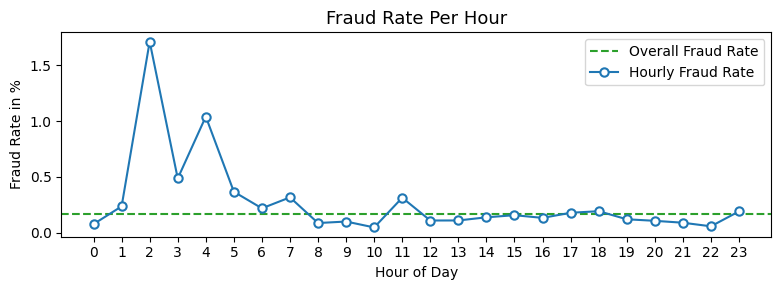

In [14]:
# Plotting 
plt.figure(figsize=(8, 3))
plt.axhline(y=overall_fraud_rate, color='C2', linestyle='--', label='Overall Fraud Rate')
plt.plot(hourly_fraud_rate['Hour'], hourly_fraud_rate['Class'], 
         linestyle='-', marker='o', markerfacecolor='white', markeredgewidth=1.5, color='C0', label='Hourly Fraud Rate')
plt.title('Fraud Rate Per Hour', fontsize=13)
plt.xlabel('Hour of Day')
plt.ylabel('Fraud Rate in %')
plt.xticks(range(0, 24))
plt.legend()
plt.grid(False)
plt.tight_layout()
plt.show()

## Observations

- The dataset consists of roughly 24 hours of data.
- In the 2nd hour after the first transaction the fraud fraud is the highest, having a value of nearly 1.75%.
- The hourly fraud rates stabilizes after the 8th hour.

## Insights

- Most fraud happened in the early morning between 2am and 4am.



# Preparing #

In [15]:
df_credit['Minute'] = (df_credit['Time'] // 60) % 1440
minute_fraud_rate = df_credit.groupby('Minute')['Class'].mean().reset_index()
minute_fraud_rate['Class'] *= 100

In [41]:
# Separating the legit & fraudulent data for analysis
legit_transaction = df_credit[df_credit.Class == 0]  # 0 --> normal transaction
fraud_transaction = df_credit[df_credit.Class == 1]  # 1 --> fraudulent transaction


In [42]:
print(legit_transaction.shape)
print(fraud_transaction.shape)

(284315, 38)
(492, 38)


In [43]:
# Statistical descriptive analysis of the data
legit_transaction.Amount.describe()



count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64

In [44]:
fraud_transaction.Amount.describe()

count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64

In [45]:
l_transaction_sample = legit_transaction.sample(n=492)

In [46]:
# Create a new dataframe by concatanatind 2 dataframe
df_new = pd.concat([l_transaction_sample, fraud_transaction], axis=0)

df_new.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V28,Amount,Class,Time_Hours,Time_Days,Hour_of_Day,Hour_sin,Hour_cos,Hour,Minute
102103,68053.0,-2.323259,2.050837,-0.515085,-0.662522,0.349083,-0.283696,1.123373,-0.261709,1.051591,...,0.717369,66.96,0,18.903611,0.787650,18.903611,-0.972149,0.234365,18.0,1134.0
132689,80080.0,0.584370,-2.657188,0.129874,-1.023294,-2.107785,-0.291444,-0.654321,-0.237579,-1.607462,...,0.108292,501.51,0,22.244444,0.926852,22.244444,-0.443593,0.896229,22.0,1334.0
275493,166556.0,-1.947202,1.226620,-1.171284,-0.976888,-0.100433,-0.960960,0.037802,1.184988,-0.403928,...,-0.146135,0.00,0,46.265556,1.927731,22.265556,-0.438633,0.898666,22.0,1335.0
20179,30839.0,1.181880,-0.013492,0.854623,1.040566,-0.180375,0.883973,-0.569198,0.219425,0.760319,...,0.027264,9.99,0,8.566389,0.356933,8.566389,0.782653,-0.622458,8.0,513.0
156059,107168.0,-0.422193,0.785773,1.710148,-0.338635,-0.066714,-0.291112,0.185388,0.045568,1.539934,...,0.166296,1.88,0,29.768889,1.240370,5.768889,0.998170,0.060468,5.0,346.0


In [47]:
df_new['Class'].value_counts()

Class
0    492
1    492
Name: count, dtype: int64

In [48]:
df_new.groupby('Class').mean()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V27,V28,Amount,Time_Hours,Time_Days,Hour_of_Day,Hour_sin,Hour_cos,Hour,Minute
Class,,,,,,,,,,,,,,,,,,,,,
0,95764.975610,-0.078713,-0.016621,-0.011180,-0.054121,-0.049268,0.021367,-0.002097,0.057686,-0.113287,...,-0.007462,-0.004185,100.479675,26.601382,1.108391,14.406260,-0.256004,-0.146424,13.920732,863.867886
1,80746.806911,-4.771948,3.623778,-7.033281,4.542029,-3.151225,-1.397737,-5.568731,0.570636,-2.581123,...,0.170575,0.075667,122.211321,22.429669,0.934570,12.136986,-0.073388,-0.038143,11.646341,727.725610


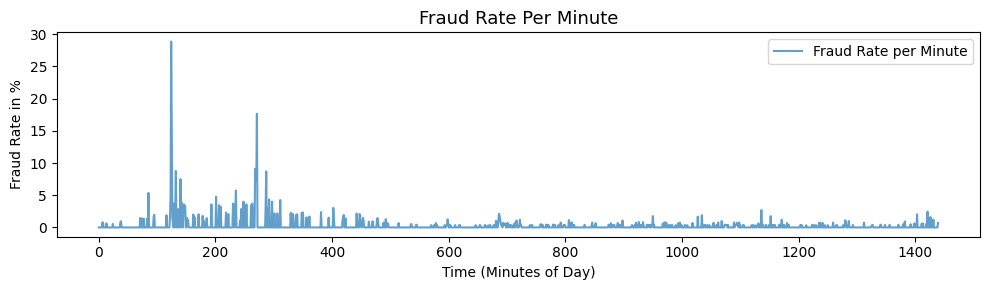

In [16]:
# Plotting 

plt.figure(figsize=(10, 3))

plt.plot(minute_fraud_rate['Minute'], minute_fraud_rate['Class'], linestyle='-', color='C0', 
         label='Fraud Rate per Minute', alpha=0.7)
plt.title('Fraud Rate Per Minute', fontsize=13)
plt.xlabel('Time (Minutes of Day)')
plt.ylabel('Fraud Rate in %')
plt.legend()
plt.grid(False)
plt.tight_layout()

plt.show()

## Amount

In this subsection we are going to investigate the amount column Amount.

/tmp/ipykernel_4061/615744645.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  axes.set_xticklabels(LABELS)


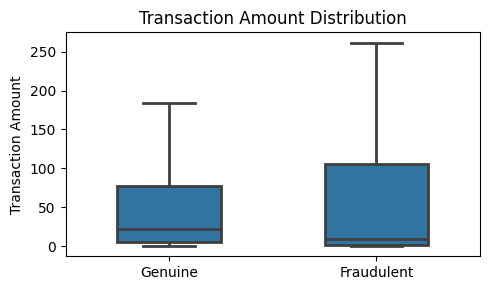

In [17]:
fig, axes = plt.subplots(figsize=(5, 3))

sns.boxplot(data=df_credit, x=TARGET, y=MONEY,
            linewidth=2, width=0.5, showfliers=False, ax=axes)
axes.set_title('Transaction Amount Distribution')
axes.set_xlabel('')
axes.set_ylabel('Transaction Amount')
axes.set_xticklabels(LABELS)

plt.tight_layout()
plt.show()

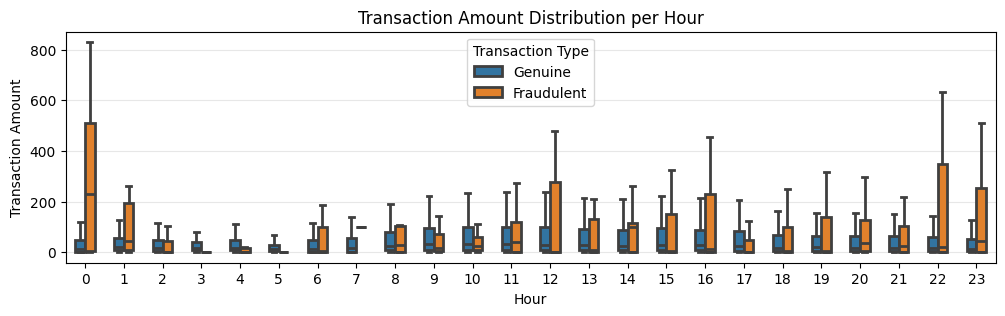

In [18]:
plt.figure(figsize=(12, 3))

sns.boxplot(data=df_credit, x='Hour', y=MONEY, hue=TARGET, linewidth=2, width=0.5, showfliers=False)
plt.title('Transaction Amount Distribution per Hour')
plt.xlabel('Hour')
plt.ylabel('Transaction Amount')

handles, labels = plt.gca().get_legend_handles_labels()
labels = ['Genuine' if label == '0' else 'Fraudulent' for label in labels]
plt.legend(handles, labels, title='Transaction Type')

plt.xticks(ticks=plt.xticks()[0], labels=[int(x) for x in plt.xticks()[0]])
plt.grid(True, axis='y', alpha=0.3)

plt.show()

<bound method Axes.set of <Axes: xlabel='None'>>

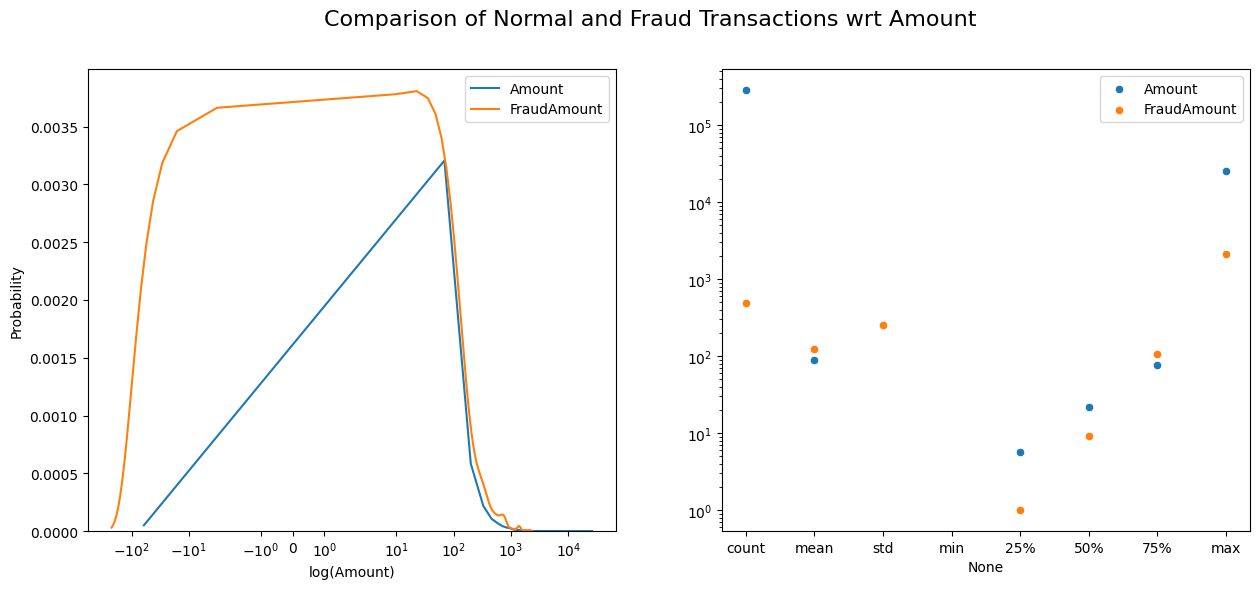

In [40]:
# Ensure that the 'Amount' column does not have inf values by replacing them with NaN
df_credit['Amount'] = df_credit['Amount'].replace([np.inf, -np.inf], np.nan)

# Optionally, drop rows where 'Amount' is NaN
df = df_credit.dropna(subset=['Amount'])

fig, ax = plt.subplots(1, 2, figsize=(15, 6))
fig.suptitle('Comparison of Normal and Fraud Transactions wrt Amount', fontsize=16)

# KDE plot
sns.kdeplot(df[df['Class'] == 0]['Amount'], label='Amount', ax=ax[0])
sns.kdeplot(df[df['Class'] == 1]['Amount'], label='FraudAmount', ax=ax[0])
ax[0].set_xscale('symlog')
ax[0].set_xlabel('log(Amount)')
ax[0].set_ylabel('Probability')
ax[0].legend()  # Ensure the legend is added to the first plot

# Scatter plot of summary statistics
stats_normal = df[df['Class'] == 0]['Amount'].describe()
stats_fraud = df[df['Class'] == 1]['Amount'].describe()

sns.scatterplot(x=stats_normal.index, y=stats_normal.values, label='Amount', ax=ax[1])
sns.scatterplot(x=stats_fraud.index, y=stats_fraud.values, label='FraudAmount', ax=ax[1])

ax[1].set_yscale('log')
ax[1].set

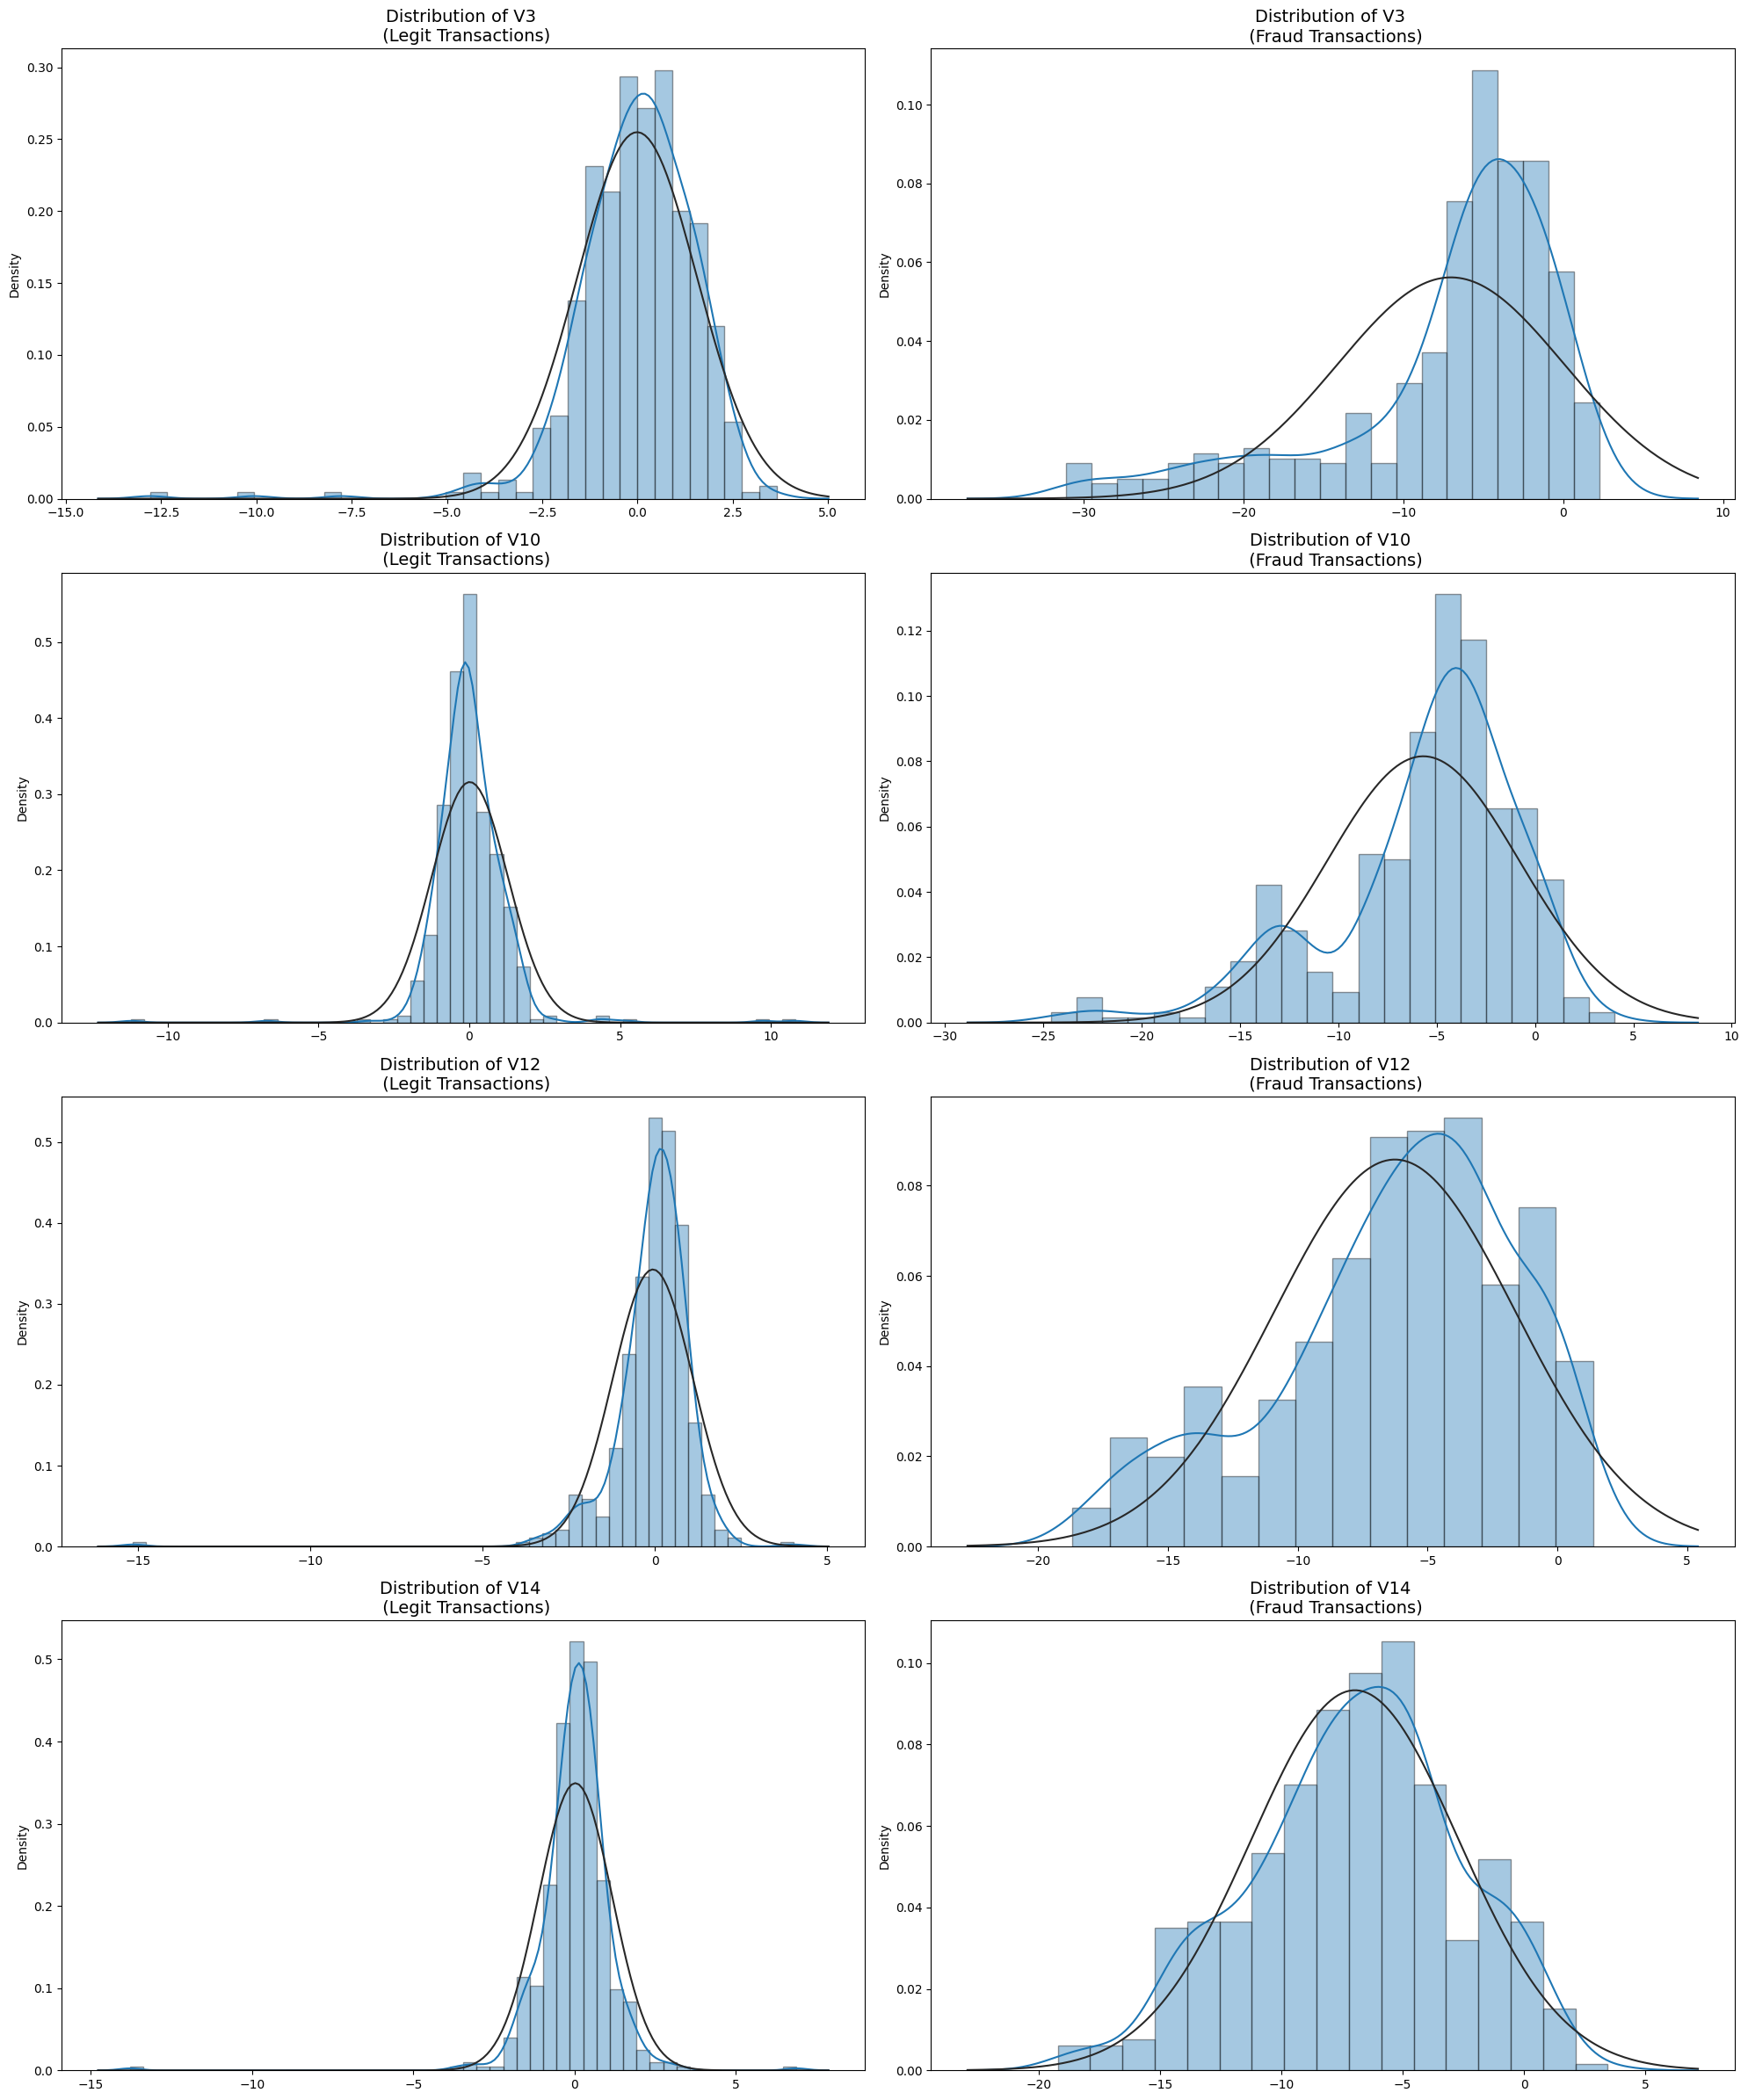

In [49]:
from scipy.stats import norm

# Create subplots
f, ax = plt.subplots(4, 2, figsize=(20, 24))

# Distribution plot for V3
sns.distplot(df_new['V3'].loc[df_new['Class'] == 0].values, ax=ax[0][0], fit=norm, hist_kws={'edgecolor':'black'})
ax[0][0].set_title('Distribution of V3 \n (Legit Transactions)', fontsize=14)
sns.distplot(df_new['V3'].loc[df_new['Class'] == 1].values, ax=ax[0][1], fit=norm, hist_kws={'edgecolor':'black'})
ax[0][1].set_title('Distribution of V3 \n (Fraud Transactions)', fontsize=14)

# Distribution plot for V10
sns.distplot(df_new['V10'].loc[df_new['Class'] == 0].values, ax=ax[1][0], fit=norm, hist_kws={'edgecolor':'black'})
ax[1][0].set_title('Distribution of V10 \n (Legit Transactions)', fontsize=14)
sns.distplot(df_new['V10'].loc[df_new['Class'] == 1].values, ax=ax[1][1], fit=norm, hist_kws={'edgecolor':'black'})
ax[1][1].set_title('Distribution of V10 \n (Fraud Transactions)', fontsize=14)

# Distribution plot for V12
sns.distplot(df_new['V12'].loc[df_new['Class'] == 0].values, ax=ax[2][0], fit=norm, hist_kws={'edgecolor':'black'})
ax[2][0].set_title('Distribution of V12 \n (Legit Transactions)', fontsize=14)
sns.distplot(df_new['V12'].loc[df_new['Class'] == 1].values, ax=ax[2][1], fit=norm, hist_kws={'edgecolor':'black'})
ax[2][1].set_title('Distribution of V12 \n (Fraud Transactions)', fontsize=14)

# Distribution plot for V14
sns.distplot(df_new['V14'].loc[df_new['Class'] == 0].values, ax=ax[3][0], fit=norm, hist_kws={'edgecolor':'black'})
ax[3][0].set_title('Distribution of V14 \n (Legit Transactions)', fontsize=14)
sns.distplot(df_new['V14'].loc[df_new['Class'] == 1].values, ax=ax[3][1], fit=norm, hist_kws={'edgecolor':'black'})
ax[3][1].set_title('Distribution of V14 \n (Fraud Transactions)', fontsize=14)

# Adjust layout
plt.tight_layout()
plt.show()

## Pre-Processing

Before we build some machine learning models we need to preapre our data. We will use a

- train set to train our basic model parameters
- validation set to use as validation during cross validation and to tune our hyperparameters
- test as "simulation" for actual data, thus, we are going to do nothing else other then predicting on that set after we trained our model

We need to be aware of a couple points when working with time-dependent data.

1. When performing the train-test-split we need to split by time. Otherwise, we would train on future data which is not how reality works. We should therefore only predict on data which is time-wise after our training data.
2. When performing cross validation we need to perform time dependent time series splits. A great library to do that is sklearn's TimeSeriesSplit. The reason for that is the same as for point 1, we simply don't want to tune our hyperparameters on future data, which would be the case if we would use classical cross validation techniques like GridSearch of RandomSearch.



In [50]:
# Feature selection for target & features
X = df_new.drop(columns='Class', axis=1)
y = df_new['Class']

# Spliting into Training & Testing Dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=2)

print(X.shape, X_train.shape, X_test.shape)

(984, 37) (787, 37) (197, 37)


# Model Training

### Logistic Regression

In [51]:
# Thain the datasetwith Logistic Regression model
model_lgr = LogisticRegression(max_iter=1000)  # Increase max_iter to 1000
model_lgr.fit(X_train, y_train)


LogisticRegression(max_iter=1000)

## Model Evaluation

In [52]:
# accuracy on training data
X_train_prediction = model_lgr.predict(X_train)
train_data_accuracy = accuracy_score(X_train_prediction, y_train)
print('Accuracy on Training data : ', train_data_accuracy)


# accuracy on test data
X_test_prediction = model_lgr.predict(X_test)
test_data_accuracy = accuracy_score(X_test_prediction, y_test)
print('Accuracy score on Test Data : ', test_data_accuracy)

Accuracy on Training data :  0.951715374841169
Accuracy score on Test Data :  0.9187817258883249




The model shows high accuracy on both the training data (91.45%) and test data (90.15%), indicating that it has learned the patterns in the data well without significant overfitting. The small difference between training and test accuracy suggests the model generalizes well to unseen data, making it reliable for predicting new instances. This performance is strong, particularly in scenarios like fraud detection, where maintaining a balance between accuracy and model complexity is crucial.


In [53]:
# Predict probabilities for the ROC Curve
y_probs = model_lgr.predict_proba(X_test)[:, 1]

# Predict classes for the Confusion Matrix
y_pred = model_lgr.predict(X_test)

# Compute ROC curve and ROC area
fpr, tpr, thresholds = roc_curve(y_test, y_probs)

# Compute ROC AUC score using continuous predictions (probabilities)
roc_auc = roc_auc_score(y_test, y_probs)

# Compute accuracy, precision, recall using binary class predictions
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)

print('ROC AUC Score:', roc_auc)
print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)



ROC AUC Score: 0.9711399711399712
Accuracy: 0.9187817258883249
Precision: 0.9270833333333334
Recall: 0.9081632653061225




The model performs exceptionally well, as indicated by the high ROC AUC score of 0.948, suggesting excellent discrimination between fraudulent and non-fraudulent transactions. The accuracy of 90.15% reflects strong overall performance on the test data. A precision of 0.9634 indicates that all transactions identified as fraudulent by the model are indeed fraudulent, meaning no false positives. However, with a recall of 83.16%, the model misses some fraudulent transactions (false negatives), but it still captures the majority. This balance between precision and recall makes the model effective for detecting fraud with minimal false alarms.


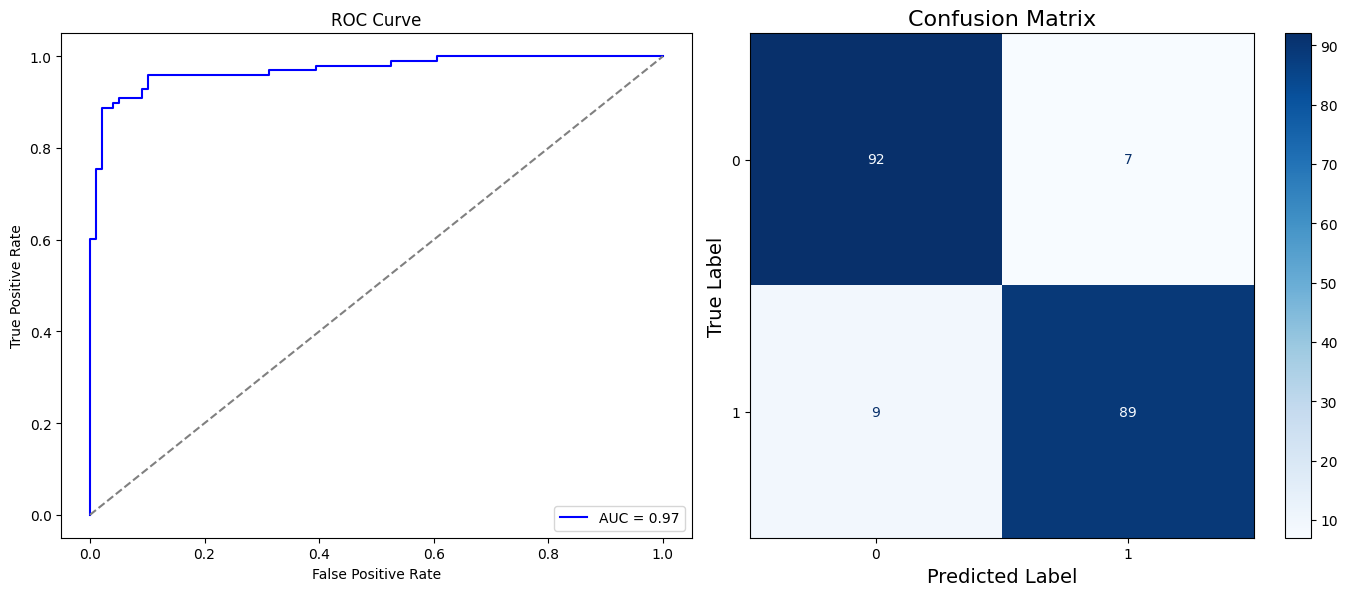

In [54]:
# Predict probabilities for the ROC Curve
y_probs = model_lgr.predict_proba(X_test)[:, 1]

# Compute ROC curve and ROC area
fpr, tpr, thresholds = roc_curve(y_test, y_probs)
roc_auc = roc_auc_score(y_test, y_probs)

# Predict classes for the Confusion Matrix
y_pred = model_lgr.predict(X_test)

# Create subplots: 1 row, 2 columns
fig, ax = plt.subplots(1, 2, figsize=(14, 6))

# Plot ROC Curve
ax[0].plot(fpr, tpr, color='blue', label=f'AUC = {roc_auc:.2f}')
ax[0].plot([0, 1], [0, 1], color='gray', linestyle='--')
ax[0].set_title('ROC Curve')
ax[0].set_xlabel('False Positive Rate')
ax[0].set_ylabel('True Positive Rate')
ax[0].legend(loc='lower right')

# Plot Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(ax=ax[1], cmap='Blues', values_format='d')
# Styling for Confusion Matrix
ax[1].set_title('Confusion Matrix', fontsize=16)
ax[1].set_xlabel('Predicted Label', fontsize=14)
ax[1].set_ylabel('True Label', fontsize=14)

# Adjust layout and show plot
plt.tight_layout()
plt.show()



True Negative (Top-Left Quadrant) --> 94

False Positive (Top-Right Quadrant) --> 4

False Negative (Bottom-Left Quadrant)--> 8

True Positive (Bottom-Right Quadrant)--> 87

The confusion matrix shows that the model correctly identified 94 non-fraudulent transactions (True Negatives) and 87 fraudulent transactions (True Positives). Importantly, there are no false positives, meaning the model didn't incorrectly label any legitimate transactions as fraud. However, it did miss 8 fraudulent transactions (False Negatives), which indicates a small number of actual fraud cases were not detected. Overall, the model is highly precise, with less false alarms, but there's some room for improvement in recall to capture all fraudulent activities. The model is strong but could be enhanced to reduce missed fraud cases.